# Stock Price Forecasting: LSTM with PyTorch

In [42]:
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from copy import deepcopy as dc
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [2]:
# I downloaded this directly from Yahoo finance but we could use an API (most of them cost money hence not using an API)
df = pd.read_csv("./data/AMZN.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
# Drop columns we won't be using
df.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

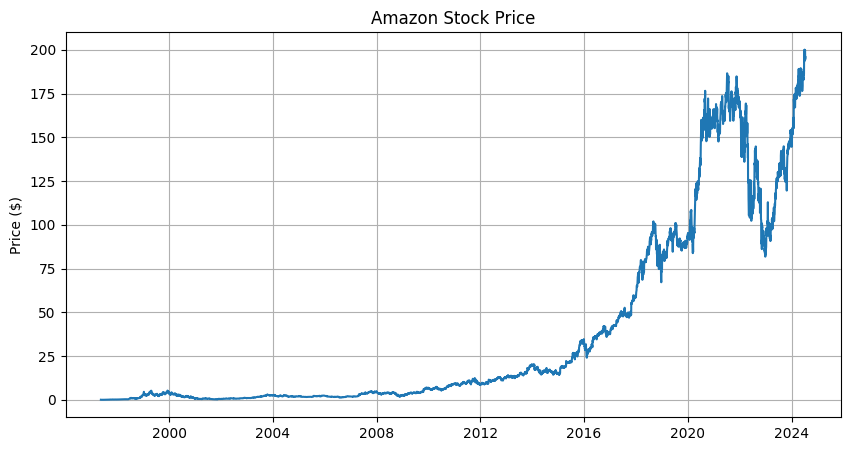

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.ylabel("Price ($)")
plt.title("Amazon Stock Price")
plt.grid()
plt.show()

Transform data to the windowed format i.e. for each date the row is (target, target - 1, target - 2, ...)

In [5]:
def df_to_windowed(dataframe, window_size=7):
    df = dc(dataframe)
    for i in range(1, window_size+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

In [6]:
df = df_to_windowed(df)
df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [7]:
df_np = df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
df_np = scaler.fit_transform(df_np)
df_np.shape

(6828, 8)

Now we split our data into our train test split, remember we cannot split randomly since order matters in this kind of task.

In [11]:
X, y = df_np[:, 1:], df_np[:, 0]

# Flip so df reads close, close - 7, close - 6, ... rather than starting at close - 1
X = dc(np.flip(X, axis=1))

# Train test split
split_idx = int(len(X) * 0.9)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [14]:
# Need to do this weird re-shaping for PyTorch
window_size = 7
X_train = X_train.reshape((-1, window_size, 1))
X_test = X_test.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [15]:
# Convert all the numpy arrays to torch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

Now we make a dataset using the standard PyTorch custom class implementation.

In [35]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        super(TimeSeriesDataset, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [36]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [37]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Now not required but useful for visualisation...

In [38]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 7, 1]) torch.Size([32, 1])


Now we build the actual model

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input_size = number of features
        # hidden_size = dimensionality of the model
        # num_stacked_layers = how many lSTMs to stack on top of each other
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [53]:
model = LSTM(1, 4, 1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [52]:
def train_one_epoch():
    model.train()
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 99: # Print every 100 batches
            avg_batch_loss = running_loss / 100
            print(f'Batch {batch_idx}, Loss: {avg_batch_loss:.3f}')
            running_loss = 0.0
    print()

In [51]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_idx, batch in enumerate(test_loader):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        

    avg_loss_cross_batch = running_loss / len(test_loader)
    print(f'Validation loss: {avg_loss_cross_batch:.3f}')
    print('********************************************\n')

In [54]:
learning_rate = 0.001
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 99, Loss: 0.628

Validation loss: 0.678
********************************************

Epoch: 2
Batch 99, Loss: 0.095

Validation loss: 0.143
********************************************

Epoch: 3
Batch 99, Loss: 0.012

Validation loss: 0.068
********************************************

Epoch: 4
Batch 99, Loss: 0.008

Validation loss: 0.046
********************************************

Epoch: 5
Batch 99, Loss: 0.005

Validation loss: 0.027
********************************************

Epoch: 6
Batch 99, Loss: 0.003

Validation loss: 0.018
********************************************

Epoch: 7
Batch 99, Loss: 0.002

Validation loss: 0.013
********************************************

Epoch: 8
Batch 99, Loss: 0.001

Validation loss: 0.010
********************************************

Epoch: 9
Batch 99, Loss: 0.000

Validation loss: 0.008
********************************************

Epoch: 10
Batch 99, Loss: 0.000

Validation loss: 0.008
***********************************

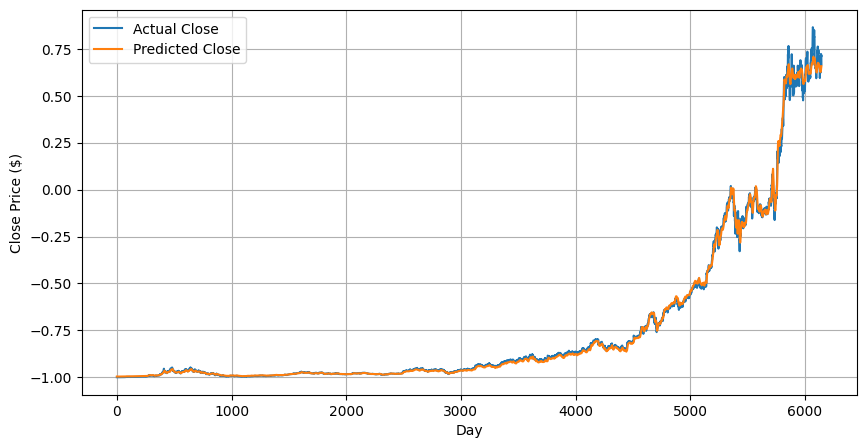

In [57]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(10, 5))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.grid()
plt.show()

# Scales are wrong because of the min-max scaling we did, that's okay :)

In [61]:
train_predicitions = predicted.flatten()
dummies = np.zeros((X_train.shape[0], window_size + 1))
dummies[:,0] = train_predicitions
dummies = scaler.inverse_transform(dummies)

train_predicitions = dc(dummies[:, 0])
train_predicitions

array([  0.44115063,   0.43840979,   0.43699766, ..., 164.83722972,
       165.32397357, 165.81749207])

In [63]:
dummies = np.zeros((X_train.shape[0], window_size + 1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

y_train_inverse_scale = dc(dummies[:, 0])

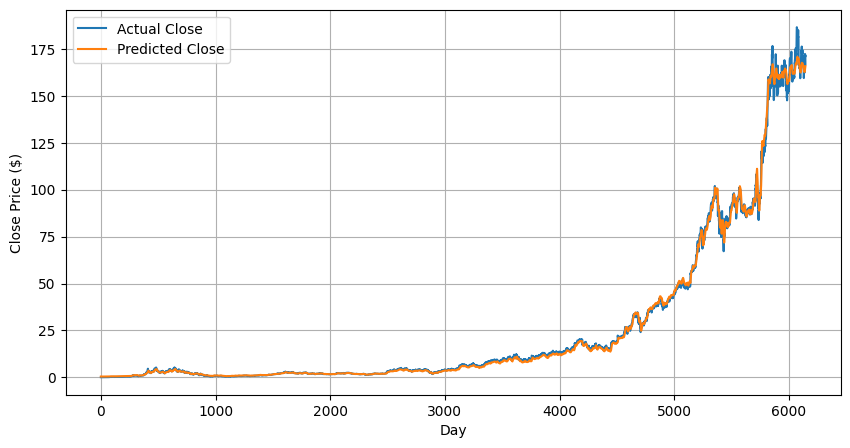

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(y_train_inverse_scale, label='Actual Close')
plt.plot(train_predicitions, label='Predicted Close')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.grid()
plt.show()

# Scales are wrong because of the min-max scaling we did, that's okay :)

In [65]:
# Now do the same thing with the test data
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()

test_predicitions = predicted_test.flatten()
dummies = np.zeros((X_test.shape[0], window_size + 1))
dummies[:,0] = test_predicitions
dummies = scaler.inverse_transform(dummies)
test_predicitions = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], window_size + 1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
y_test_inverse_scale = dc(dummies[:, 0])

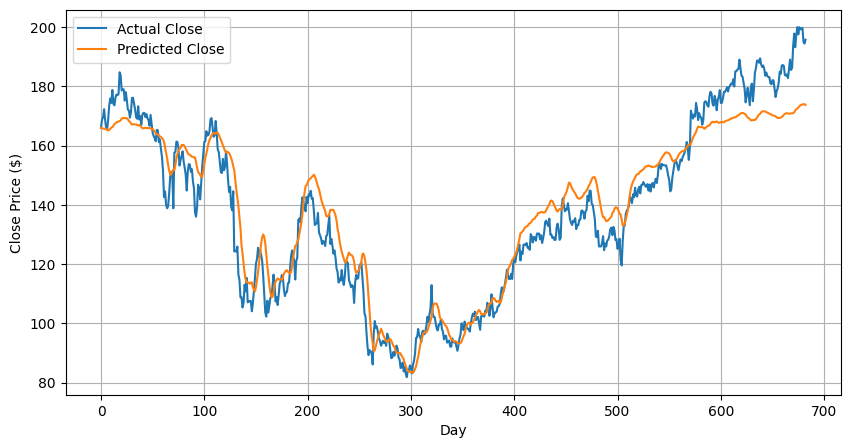

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse_scale, label='Actual Close')
plt.plot(test_predicitions, label='Predicted Close')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.grid()
plt.show()

# Scales are wrong because of the min-max scaling we did, that's okay :)

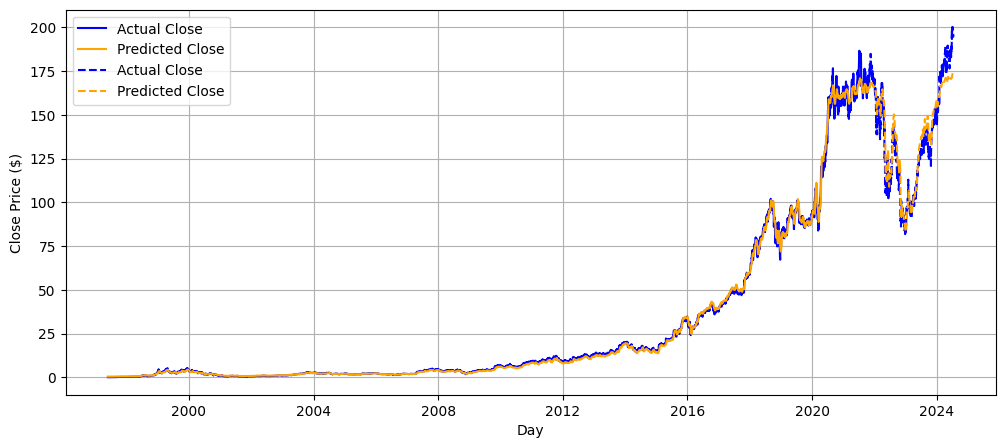

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(df[:split_idx].index, y_train_inverse_scale, label='Actual Close', color="blue")
plt.plot(df[:split_idx].index, train_predicitions, label='Predicted Close', color="orange")
plt.plot(df[split_idx:].index, y_test_inverse_scale, label='Actual Close', linestyle="--", color="blue")
plt.plot(df[split_idx:].index, test_predicitions, label='Predicted Close', linestyle="--", color="orange")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.grid()
plt.show()

# Scales are wrong because of the min-max scaling we did, that's okay :)